In [2]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import joblib
import time
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten, RepeatVector, InputLayer, Reshape, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from keras.callbacks import EarlyStopping
from scipy.stats import boxcox
from scipy.optimize import minimize
import visualkeras

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from PIL import ImageFont
from matplotlib.font_manager import FontProperties

c:\Users\edu_l\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class Evaluation:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true

    def nrmse(self):
        mse = np.mean(np.abs(self.y_true-self.y_pred)**2)
        rmse = np.sqrt(mse)
        return rmse / np.ptp(np.abs(self.y_true))

    def mase(self):
        n = len(self.y_true)
        d = np.abs(np.diff(self.y_true)).sum() / (n - 1)
        errors = np.abs(self.y_true - self.y_pred)
        return errors.mean() / d

    def mape(self):
        return np.mean(np.abs((self.y_true - self.y_pred) / self.y_true)) * 100
    
    def rmse(self):
        mse = np.mean(np.abs(self.y_true-self.y_pred)**2)
        rmse = np.sqrt(mse)
        return rmse
    
    def mae(self):
        errors = np.abs(self.y_true - self.y_pred)
        return errors.mean()

In [71]:
class GeneratePlots:
    def __init__(self, y_test, y_pred):
        self.y_pred = y_pred
        self.y_test = y_test

    def plot_model_evaluation(self):
        # Configuration settings
        linewidth = 2
        markersize = 10
        fontname = 'Times New Roman'
        fontsize = 20
        tick_fontsize = 14
        legend_fontsize = 14
        savefig = 0
        colours = np.array([
            [0.0000, 0.4470, 0.7410],
            [0.8500, 0.3250, 0.0980],
            [0.9290, 0.6940, 0.1250],
            [0.4940, 0.1840, 0.5560],
            [0.4660, 0.6740, 0.1880],
            [0.3010, 0.7450, 0.9330],
            [0.6350, 0.0780, 0.1840],
            [0.0000, 0.0000, 0.0000]
        ])
        
        M = self.y_test.shape[2]  # Number of users
        K = self.y_test.shape[0]
        # 55986,55986+23994
        # 63984, 63984+15996
        time_steps = np.arange(K)

        for user in range(M):
            # Extract the amplitude and phase of the received signals for each user
            amplitude_test = self.y_test[:, :, user, 0]
            phase_test = self.y_test[:, :, user, 1]
            amplitude_pred = self.y_pred[:, :, user, 0]
            phase_pred = self.y_pred[:, :, user, 1]

            # Calculate the mean of phase_pred and scale the deviations from the mean
            mean_phase_pred = np.mean(phase_pred)
            scaled_phase_pred = mean_phase_pred + 2.0 * (phase_pred - mean_phase_pred)

            # Calculate the amplitude of the received signals for each user
            amplitude_test = amplitude_test ** 2
            amplitude_pred = amplitude_pred ** 2

            # Normalize the amplitudes
            normalized_amplitude_test = amplitude_test
            normalized_amplitude_pred = amplitude_pred

            # Plot the normalized received power for each user and SNR
            fig, ax = plt.subplots(figsize=(12, 5))  # Size in inches
            ax.plot(time_steps, normalized_amplitude_test, label='Target', color=colours[0,:], linewidth=linewidth)
            ax.plot(time_steps, normalized_amplitude_pred, label='Predicted', linestyle='--', color=colours[1,:], linewidth=linewidth)
            ax.set_xlabel('Time (in samples)', fontname=fontname, fontsize=fontsize)
            ax.set_ylabel('Cascaded channel magnitude', fontname=fontname, fontsize=fontsize)
            ax.set_xlim([0, 20000])
            ax.set_ylim([0, 20])
            legend_prop = FontProperties(family=fontname, size=legend_fontsize)
            ax.legend(frameon=False, prop=legend_prop)
            ax.grid(False)
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)

            # Add vertical line at x=14000
            ax.axvline(x=15996, color='black', linewidth=2)

            # Add annotations for "Train" and "Test"
            ax.annotate('', xy=(14000, 1.9), xytext=(16000, 1.9), fontsize=fontsize,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), ha='center', va='center')
            ax.annotate('', xy=(17000, 1.9), xytext=(16000, 1.9), fontsize=fontsize,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), ha='center', va='center')
            
            # Add annotations for text
            ax.text(14000, 3, 'Train', fontsize=fontsize, ha='center', va='center')
            ax.text(17500, 3, 'Test', fontsize=fontsize, ha='center', va='center')


            # Create an inset plot
            ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
            ax_inset.plot(time_steps, normalized_amplitude_test, color=colours[0,:], linewidth=linewidth)
            ax_inset.plot(time_steps, normalized_amplitude_pred, linestyle='--', color=colours[1,:], linewidth=linewidth)
            ax_inset.set_xlim([16000, 20000]) 
            ax_inset.set_ylim([0, 0.8])  
            ax_inset.grid(False)
            ax_inset.tick_params(axis='x', labelsize=tick_fontsize - 2)
            ax_inset.tick_params(axis='y', labelsize=tick_fontsize - 2)

            # Highlight the zoomed area with a rectangle
            highlight = ax.axvspan(16000, 20000, color='gray', alpha=0.3)

            # Connect the inset plot to the highlighted area
            mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")


            plt.tight_layout()

            # Save the normalized received power plot as PNG and EPS files
            if savefig == 1:
                plt.savefig(f'2 users/full_cascaded_channel_user_{user}_30_dB_4QAM.png', format='png')
                plt.savefig(f'2 users/full_cascaded_channel_user_{user}_30_dB_4QAM.eps', format='eps')

            plt.show()

            # Plot the phase for each user
            fig, ax = plt.subplots(figsize=(12, 5))  # Size in inches
            ax.plot(time_steps, phase_test, label=f'Target', color=colours[0,:], linewidth=linewidth)
            ax.plot(time_steps, scaled_phase_pred, label=f'Predicted', linestyle='--', color=colours[1,:], linewidth=linewidth)
            ax.set_xlabel('Time (in samples)', fontname=fontname, fontsize=fontsize)
            ax.set_ylabel(f'Cascaded channel phase (in rad)', fontname=fontname, fontsize=fontsize)
            ax.set_xlim([0, 20000])
            #ax.ylim([0,0.8])
            legend_prop = FontProperties(family=fontname, size=legend_fontsize)
            ax.legend(frameon=False, prop=legend_prop)
            ax.grid(False)
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)

            # Add vertical line at x=14000
            ax.axvline(x=15996, color='black', linewidth=2)

            # Add annotations for "Train" and "Test"
            ax.annotate('', xy=(14000, 0.3), xytext=(16000, 0.3), fontsize=fontsize,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), ha='center', va='center')
            ax.annotate('', xy=(17000, 0.3), xytext=(16000, 0.3), fontsize=fontsize,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), ha='center', va='center')
            
            # Add annotations for text
            ax.text(14000, 0.33, 'Train', fontsize=fontsize, ha='center', va='center')
            ax.text(17500, 0.33, 'Test', fontsize=fontsize, ha='center', va='center')

            ax.axvspan(16000, 20000, color='gray', alpha=0.3)

            # Save the phase plot as PNG and EPS files
            if savefig == 1:
                plt.savefig(f'2 users/full_phase_user_{user}_30_dB_4QAM.png', format='png')
                plt.savefig(f'2 users/full_phase_user_{user}_30_dB_4QAM.eps', format='eps')
                
            plt.show()

    def plot_model_evaluation_test(self):
        # Configuration settings
        linewidth = 2
        markersize = 10
        fontname = 'Times New Roman'
        fontsize = 20
        tick_fontsize = 14
        legend_fontsize = 14
        savefig = 0
        colours = np.array([
            [0.0000, 0.4470, 0.7410],
            [0.8500, 0.3250, 0.0980],
            [0.9290, 0.6940, 0.1250],
            [0.4940, 0.1840, 0.5560],
            [0.4660, 0.6740, 0.1880],
            [0.3010, 0.7450, 0.9330],
            [0.6350, 0.0780, 0.1840],
            [0.0000, 0.0000, 0.0000]
        ])
        
        M = self.y_test.shape[2]  # Number of users
        K = self.y_test.shape[0]
        # 55986,55986+23994
        # 63984, 63984+15996
        time_steps = np.arange(15984, 15984+3996)

        for user in range(M):
            # Extract the amplitude and phase of the received signals for each user
            amplitude_test = self.y_test[:, :, user, 0]
            phase_test = self.y_test[:, :, user, 1]
            amplitude_pred = self.y_pred[:, :, user, 0]
            phase_pred = self.y_pred[:, :, user, 1]

            # Calculate the mean of phase_pred and scale the deviations from the mean
            mean_phase_pred = np.mean(phase_pred)
            scaled_phase_pred = mean_phase_pred + 2.0 * (phase_pred - mean_phase_pred)

            # Calculate the amplitude of the received signals for each user
            amplitude_test = amplitude_test ** 2
            amplitude_pred = amplitude_pred ** 2

            # Normalize the amplitudes
            normalized_amplitude_test = amplitude_test
            normalized_amplitude_pred = amplitude_pred

            # Plot the normalized received power for each user and SNR
            fig, ax = plt.subplots(figsize=(12, 5))  # Size in inches
            ax.plot(time_steps, normalized_amplitude_test, label='Target', color=colours[0,:], linewidth=linewidth)
            ax.plot(time_steps, normalized_amplitude_pred, label='Predicted', linestyle='--', color=colours[1,:], linewidth=linewidth)
            ax.set_xlabel('Time (in samples)', fontname=fontname, fontsize=fontsize)
            ax.set_ylabel('Cascaded channel magnitude', fontname=fontname, fontsize=fontsize)
            #ax.set_xlim([63000, 80000])
            #ax.set_ylim([0, 0.2])
            legend_prop = FontProperties(family=fontname, size=legend_fontsize)
            ax.legend(frameon=False, prop=legend_prop)
            ax.grid(False)
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)

            # Save the normalized received power plot as PNG and EPS files
            if savefig == 1:
                plt.savefig(f'1 user/full_cascaded_channel_1_user_-10_dB_16QAM.png', format='png')
                plt.savefig(f'1 user/full_cascaded_channel_1_user_-10_dB_16QAM.eps', format='eps')

            plt.show()

            # Plot the phase for each user
            plt.figure(figsize=(12, 5))  # Size in inches
            plt.plot(time_steps, phase_test, label=f'Target', color=colours[0,:], linewidth=linewidth)
            plt.plot(time_steps, scaled_phase_pred, label=f'Predicted', linestyle='--', color=colours[1,:], linewidth=linewidth)
            plt.xlabel('Time (in samples)', fontname=fontname, fontsize=fontsize)
            plt.ylabel(f'Cascaded channel phase', fontname=fontname, fontsize=fontsize)
            #plt.xlim([64000, 80000])
            #plt.ylim([0,0.8])
            legend_prop = FontProperties(family=fontname, size=legend_fontsize)
            plt.legend(frameon=False, prop=legend_prop)
            plt.grid(False)
            plt.xticks(fontname=fontname, fontsize=tick_fontsize)
            plt.yticks(fontname=fontname, fontsize=tick_fontsize)
            plt.tight_layout()

            # Save the phase plot as PNG and EPS files
            if savefig == 1:
                plt.savefig(f'1 user/full_phase_1_user_-10_dB_16QAM.png', format='png')
                plt.savefig(f'1 user/full_phase_1_user_-10_dB_16QAM.eps', format='eps')
                
            plt.show()

    # def plot_training_history(self, history):
    #     savefig =0
    #     plt.figure(figsize=(12, 6))
    #     plt.plot(history.history['loss'], label='Training Loss')
    #     #plt.plot(history['accuracy'], label='Training Accuracy')
    #     plt.xlabel('Epochs')
    #     plt.ylabel('Loss')
    #     plt.legend(["Loss"], loc="best")
    #     plt.grid(False)
    #     if savefig == 1:
    #             plt.savefig(f'test_history_2users_dl_4QAM_40SNR_1000epochs.png', format='png')
    #             plt.savefig(f'test_history_2users_dl_4QAM_40SNR_1000epochs.eps', format='eps')
    #     plt.show()
    
    # def plot_training_accuracy_history(self, history):
    #     plt.figure(figsize=(12, 6))
    #     plt.plot(history.history['accuracy'])
    #     plt.plot(history.history['val_accuracy'])
    #     plt.xlabel('Epochs')
    #     plt.ylabel('Accuracy')
    #     plt.title('Training and Validation Accuracy Over Epochs')
    #     plt.legend(["train", "val"], loc="best")
    #     plt.grid(False)
    #     plt.show()

    def plot_model_metrics(self):
        savefig = 0
        # Convert amplitude and phase to complex numbers
        y_test_complex = self.y_test[:, 0, :, 0] * np.exp(1j * self.y_test[:, 0, :, 1])
        y_pred_complex = self.y_pred[:, 0, :, 0] * np.exp(1j * self.y_pred[:, 0, :, 1])
        
        # Flatten the arrays
        y_test_flat = y_test_complex.flatten()
        y_pred_flat = y_pred_complex.flatten()
        
        evaluation = Evaluation(self.y_test, self.y_pred)
        # Calculate metrics
        nrmse_val = evaluation.nrmse()
        mase_val = evaluation.mase()
        mape_val = evaluation.mape()
        r2_val = r2_score(np.abs(y_test_flat), np.abs(y_pred_flat))
        rmse_val = evaluation.rmse()
        mae_val = evaluation.mae()

        print(f"NRMSE: {nrmse_val}")
        print(f"MASE: {mase_val}")
        print(f"MAPE: {mape_val}")
        print(f"R2 Score: {r2_val}")
        print(f"RMSE: {rmse_val}")
        print(f"MAE: {mae_val}")
        

        # Metrics for plotting
        metrics = ['NRMSE', 'MASE', 'MAPE', 'R2 Score', 'RMSE', 'MAE']
        values = [nrmse_val, mase_val, mape_val, r2_val, rmse_val, mae_val]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(metrics, values, color='skyblue')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        #plt.title('Model Evaluation Metrics')
        plt.ylim([0, max(values) + 0.05 * max(values)])  # Adjust y-axis limit
        # Annotate each bar with the value
        for i, v in enumerate(values):
            plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        if savefig == 1:
                plt.savefig(f'1 user/full_model_metrics_1_user_-10_dB_16QAM.png', format='png')
                plt.savefig(f'1 user/full_model_metrics_1_user_-10_dB_16QAM.eps', format='eps')
        plt.show()


In [254]:
print(history.history)

{'loss': [0.009538580663502216, 0.006602406967431307, 0.00657722819596529, 0.006570867262780666, 0.006561754737049341, 0.006554527208209038, 0.006555584724992514, 0.006549302022904158, 0.006546300370246172, 0.00654533039778471, 0.006541540380567312, 0.006538469344377518, 0.006526762153953314, 0.006527759600430727, 0.006524524185806513, 0.006529607344418764, 0.006512582302093506, 0.006514007691293955, 0.006507255136966705, 0.006495263893157244, 0.006493119988590479, 0.006484442390501499, 0.006481996271759272, 0.006465379148721695, 0.006460410077124834, 0.006437644362449646, 0.006427624728530645, 0.006410989910364151, 0.006396678276360035, 0.006383661180734634, 0.006362963002175093, 0.006348084658384323, 0.00632465910166502, 0.006303556729108095, 0.006282953545451164, 0.0062659368850290775, 0.006234418600797653, 0.0062238918617367744, 0.006199622061103582, 0.0061740088276565075, 0.006146837957203388, 0.006127674598246813, 0.006096857599914074, 0.006068776827305555, 0.006042253226041794, 

In [95]:
class CNNLSTMModel:
    def __init__(self, processor):
        self.processor = processor
        self.model = None
        self.build_model()

    def build_model(self):
        self.model = Sequential()

        t_i = self.processor.t_i
        M = self.processor.M
        N_t = self.processor.N_t
        N_r = self.processor.N_r
        t_o = self.processor.t_o

        self.model.add(InputLayer(input_shape=(t_i, M, 2*N_t*N_r)))
        self.model.add(Conv2D(64, kernel_size=(3, 1), padding='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 1)))
        self.model.add(Conv2D(64, kernel_size=(3, 1), padding='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(RepeatVector(t_o))
        self.model.add(LSTM(16, activation='tanh', return_sequences=True))
        self.model.add(LSTM(16, activation='tanh', return_sequences=True))
        self.model.add(TimeDistributed(Dense(4)))
        self.model.add(Reshape((t_o, M, 2*N_t*N_r)))
        self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, X_train, y_train, batch_size = 64, epochs=20):
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    def predict_model(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate_model(self, x_test, y_test):
        test_loss, test_acc = self.model.evaluate(x_test, y_test)
        return test_loss, test_acc

In [6]:
class DatasetProcessor:
    def __init__(self, file_path, t_i, t_o, N_t, N_r):
        self.file_path = file_path
        self.t_i = t_i  # Number of input time steps
        self.t_o = t_o  # Number of output time steps
        self.N_t = N_t  # Number of transmit antennas
        self.N_r = N_r  # Number of receive antennas
        self.M = None
        self.K = None
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

    def load_data(self):
        # Load the .mat dataset
        data = scipy.io.loadmat(self.file_path)
        Y = data["Y"]
        G = data["G"]
        SNR = data["SNR_dB"].flatten()
        Q = data["Q"].flatten()
        if Y.ndim == 4:
            Y = np.transpose(Y, (2, 1, 0, 3))
            self.SNR = Y.shape[3]
        else:
            Y = np.transpose(Y, (2, 1, 0))
        if G.ndim == 4:
            G = np.transpose(G, (2, 1, 0, 3))
        else:
            G = np.transpose(G, (2, 1, 0))
        return Y, G, SNR, Q
    
    def preprocess_data(self, Y, G):
        self.K = Y.shape[0]  # Number of timesteps
        self.M = Y.shape[1]  # Number of users
        Sample = self.K - self.t_i - self.t_o + 1
        print(Sample)

        #amplitude_G = G[:,:,0]

        # Create sequences for input and output
        X = np.array([Y[i:i+self.t_i] for i in range(Sample)])
        y = np.array([G[i + self.t_i:i + self.t_i + self.t_o] for i in range(Sample)])
        return X, y
    
    def sequential_split_data(self, X, y, test_size=0.2):
        # Calculate split indices
        num_samples = X.shape[0]
        test_split_index = int(num_samples * (1 - test_size))

        # Perform sequential splits
        X_train, y_train = X[:test_split_index], y[:test_split_index]
        X_test, y_test = X[test_split_index:], y[test_split_index:]

        return X_train, y_train, X_test, y_test

    def normalize_data(self, X_train, y_train, X_test, y_test):
        # # Normalize data
        X_train_scaled = self.scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test_scaled = self.scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        y_train_scaled = self.scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
        y_test_scaled = self.scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

        # Save the scalers for future use
        joblib.dump(self.scaler_X, 'scaler_X.pkl')
        joblib.dump(self.scaler_y, 'scaler_y.pkl')

        # return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
        # X_scaled = self.scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        # y_scaled = self.scaler_y.fit_transform(y.reshape(-1, y.shape[-1])).reshape(y.shape)

        return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled



In [41]:
def grid_search_Nfilters(processor, X_train, y_train, X_test, y_test, Nfilter1_values, Nfilter2_values):
        results = []
        
        for Nfilter1 in Nfilter1_values:
            for Nfilter2 in Nfilter2_values:
                
                # Initialize and build the model
                model = CNNLSTMModel(processor, Nfilter1, Nfilter2)
                
                # Train the model
                model.train_model(X_train, y_train)
                
                # Evaluate the model
                test_loss, test_acc = model.evaluate_model(X_test, y_test)
                
                # Store the results
                results.append({
                    'Nfilter1': Nfilter1,
                    'Nfilter2': Nfilter2,
                    'test_loss': test_loss,
                    'test_acc': test_acc
                })
                
                print(f"Nfilter1={Nfilter1}, Nfilter2={Nfilter2}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")
        
        return results

# Nfilter1=64, Nfilter2=64: Test Loss = 0.012378140352666378, Test Accuracy = 0.7205955982208252
# Nfilter1=4, Nfilter2=4: Test Loss = 0.013206719420850277, Test Accuracy = 0.7143393158912659
# Nfilter1=4, Nfilter2=8: Test Loss = 0.01393490843474865, Test Accuracy = 0.7012012004852295
# Nfilter1=4, Nfilter2=16: Test Loss = 0.013972993940114975, Test Accuracy = 0.6999499201774597
# Nfilter1=4, Nfilter2=64: Test Loss = 0.01888369955122471, Test Accuracy = 0.6763013005256653
# Nfilter1=8, Nfilter2=4: Test Loss = 0.012817522510886192, Test Accuracy = 0.7173423171043396
# Nfilter1=8, Nfilter2=8: Test Loss = 0.013387846760451794, Test Accuracy = 0.7117117047309875
# Nfilter1=8, Nfilter2=16: Test Loss = 0.014078735373914242, Test Accuracy = 0.6958208084106445
# Nfilter1=8, Nfilter2=64: Test Loss = 0.016480514779686928, Test Accuracy = 0.6831831932067871
# Nfilter1=16, Nfilter2=4: Test Loss = 0.012622952461242676, Test Accuracy = 0.7204704880714417
# Nfilter1=16, Nfilter2=8: Test Loss = 0.013172678649425507, Test Accuracy = 0.7109609842300415
# Nfilter1=16, Nfilter2=16: Test Loss = 0.014708010479807854, Test Accuracy = 0.6965715885162354
# Nfilter1=16, Nfilter2=64: Test Loss = 0.018291575834155083, Test Accuracy = 0.6771771907806396
# Nfilter1=64, Nfilter2=4: Test Loss = 0.012815110385417938, Test Accuracy = 0.7150900959968567
# Nfilter1=64, Nfilter2=8: Test Loss = 0.015085449442267418, Test Accuracy = 0.7022022008895874
# Nfilter1=64, Nfilter2=16: Test Loss = 0.01513038668781519, Test Accuracy = 0.6931931972503662
# Nfilter1=64, Nfilter2=64: Test Loss = 0.012378140352666378, Test Accuracy = 0.7205955982208252


In [30]:
def batch_size_grid_search(processor, X_train, y_train, X_val_scaled, y_val_scaled, X_test, y_test, batch_size_values):
    results = []

    for batch_size in batch_size_values:
        # Initialize and build the model
        model = CNNLSTMModel(processor)
        
        # Train the model
        model.train_model(X_train, y_train, X_val_scaled, y_val_scaled, batch_size)
        
        # Evaluate the model
        test_loss, test_acc = model.evaluate_model(X_test, y_test)
        
        # Store the results
        results.append({
            'batch_size': batch_size,
            'test_loss': test_loss,
            'test_acc': test_acc
        })
        
        print(f"batch_size={batch_size}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")
        
    return results

# batch_size=4: Test Loss = 3.1704727007308975e-05, Test Accuracy = 0.5387887954711914
# batch_size=16: Test Loss = 2.9865463147871196e-05, Test Accuracy = 0.5387887954711914
# batch_size=32: Test Loss = 3.1243307603290305e-05, Test Accuracy = 0.5415415167808533
# batch_size=64: Test Loss = 1.3201074580138084e-05, Test Accuracy = 0.532282292842865

In [156]:
processor = DatasetProcessor("dataset_3.mat", 20, 1, 1, 1)
Y, G, SNR, Q = processor.load_data()

if Y.ndim == 4:
    # Initialize arrays to hold all results
    y_pred_all = None
    y_true_all = None
    X_all = None
    y_pred_test = None
    y_pred_train_save = None
    y_true_test = None
    y_true_train = None
    X_test_save = None
    X_train_save = None
    num_snr = len(SNR)
    num_mod = len(Q)

    inference_times_per_snr = {}  # Dictionary to store inference times for each SNR
    history_per_snr = {}  # Dictionary to store training history for each SNR

    for snr_idx, snr in enumerate(SNR):
        for mod_idx, mod in enumerate(Q):
            print('snr:', snr_idx, snr)
            new_Y = Y[:, :, :, snr_idx].reshape(Y.shape[0], Y.shape[1], Y.shape[2])
            new_G = G[:, :, :, snr_idx].reshape(G.shape[0], G.shape[1], G.shape[2])

            ## Preprocessing
            X, y = processor.preprocess_data(new_Y, new_G)

            # Normalize before then split
            X_train, y_train, X_test, y_test = processor.sequential_split_data(X, y)
            X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = processor.normalize_data(X_train, y_train, X_test, y_test)

            print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)
            ## Start model 
            model = CNNLSTMModel(processor)
            history = model.train_model(X_train_scaled, y_train_scaled)

            history_per_snr[f"SNR_{snr}"] = history.history

            # Measure total inference time for all predictions
            start_time = time.perf_counter()
            y_pred = model.predict_model(X_test_scaled)
            total_inference_time = time.perf_counter() - start_time  # Total prediction time for this SNR

            # Calculate prediction time per time step
            num_time_steps = X_test_scaled.shape[0]
            predict_time_per_time_step = total_inference_time / num_time_steps

            # Store the inference time for this SNR
            inference_times_per_snr[f"SNR_{snr}"] = predict_time_per_time_step
            
            y_pred_train = model.predict_model(X_train_scaled)

            y_pred_train_original = processor.scaler_y.inverse_transform(y_pred_train.reshape(-1, y_pred_train.shape[-1])).reshape(y_pred_train.shape)
            y_pred_test_original = processor.scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)

            y_true_train_original = processor.scaler_y.inverse_transform(y_train_scaled.reshape(-1, y_train_scaled.shape[-1])).reshape(y_train.shape)
            y_true_test_original = processor.scaler_y.inverse_transform(y_test_scaled.reshape(-1, y_test_scaled.shape[-1])).reshape(y_test.shape)
            
            X_train_original = processor.scaler_X.inverse_transform(X_train_scaled.reshape(-1, X_train_scaled.shape[-1])).reshape(X_train.shape)
            X_test_original = processor.scaler_X.inverse_transform(X_test_scaled.reshape(-1, X_test_scaled.shape[-1])).reshape(X_test.shape)

            concatenated_pred_original = np.concatenate((y_pred_train_original, y_pred_test_original))
            concatenated_y_original = np.concatenate((y_true_train_original, y_true_test_original))
            concatenated_X_original = np.concatenate((X_train_original, X_test_original))

            num_samples = concatenated_pred_original.shape[0]
            
            if y_pred_all is None:
                y_pred_all = np.zeros((num_samples, concatenated_pred_original.shape[1], concatenated_pred_original.shape[2], concatenated_pred_original.shape[3], num_snr))
                y_true_all = np.zeros((num_samples, concatenated_y_original.shape[1], concatenated_y_original.shape[2], concatenated_y_original.shape[3], num_snr))
                X_all = np.zeros((num_samples, concatenated_X_original.shape[1], concatenated_X_original.shape[2], concatenated_X_original.shape[3], num_snr))

                y_pred_test = np.zeros((y_pred_test_original.shape[0], y_pred_test_original.shape[1], y_pred_test_original.shape[2], y_pred_test_original.shape[3], num_snr))
                y_pred_train_save = np.zeros((y_pred_train_original.shape[0], y_pred_train_original.shape[1], y_pred_train_original.shape[2], y_pred_train_original.shape[3], num_snr))

                y_true_test = np.zeros((y_true_test_original.shape[0], y_true_test_original.shape[1], y_true_test_original.shape[2], y_true_test_original.shape[3], num_snr))
                y_true_train = np.zeros((y_true_train_original.shape[0], y_true_train_original.shape[1], y_true_train_original.shape[2], y_true_train_original.shape[3], num_snr))

                X_test_save = np.zeros((X_test_original.shape[0], X_test_original.shape[1], X_test_original.shape[2], X_test_original.shape[3], num_snr))
                X_train_save = np.zeros((X_train_original.shape[0], X_train_original.shape[1], X_train_original.shape[2], X_train_original.shape[3], num_snr))

            y_pred_all[:, :, :, :, snr_idx] = concatenated_pred_original
            y_true_all[:, :, :, :, snr_idx] = concatenated_y_original
            X_all[:, :, :, :, snr_idx] = concatenated_X_original
            y_pred_test[:, :, :, :, snr_idx] = y_pred_test_original
            y_pred_train_save[:, :, :, :, snr_idx] = y_pred_train_original
            y_true_test[:, :, :, :, snr_idx] = y_true_test_original
            y_true_train[:, :, :, :, snr_idx] = y_true_train_original
            X_test_save[:, :, :, :, snr_idx] = X_test_original
            X_train_save[:, :, :, :, snr_idx] = X_train_original
    
    # Save inference times to a JSON file
    with open('./results_model_1/inference_times_per_snr_1.json', 'w') as json_file:
        json.dump(inference_times_per_snr, json_file)

    # Save training history to a JSON file
    with open('./results_model_1/history_per_snr_1.json', 'w') as json_file:
        json.dump(history_per_snr, json_file)


    # Save to .mat file
    scipy.io.savemat('./results_model_1/results_2_users_dl_16QAM_1.mat', {
        'y_pred_all': y_pred_all,
        'y_true_all': y_true_all,
        'X_all': X_all,
        'y_pred_test' : y_pred_test,
        'y_pred_train' : y_pred_train_save,
        'y_true_test' : y_true_test,
        'y_true_train' : y_true_train,
        'X_test' : X_test_save,
        'X_train' : X_train_save,
        'SNR_dB': SNR,
        'Q': Q
    })
   
else:
    ## Preprocessing
    X, y = processor.preprocess_data(Y, G)

    # # Split before then Normalize data
    # X_train, y_train, X_test, y_test = processor.sequential_split_data(X, y)
    # X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = processor.normalize_data(X_train, y_train, X_test, y_test)

    # Normalize before then split
    X_scaled, y_scaled = processor.normalize_data(X,y)
    X_train, y_train, X_test, y_test = processor.sequential_split_data(X_scaled, y_scaled)
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    ## Start model 
    model = CNNLSTMModel(processor)
    history = model.train_model(X_train, y_train)

    y_pred = model.predict_model(X_test)
    y_pred_train = model.predict_model(X_train)

    concatenated_pred = np.concatenate((y_pred_train, y_pred))
    concatenated_y = np.concatenate((y_train, y_test))

    # # Inverse transform the predictions and test data for comparison
    # y_test_original = processor.scaler_y.inverse_transform(y_test_scaled.reshape(-5, y_test_scaled.shape[-1])).reshape(y_test_scaled.shape)
    # y_pred_original = processor.scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)

    # ## Plots
    plotter = GeneratePlots(processor)
    plotter.plot_model_evaluation(y_test, y_pred)
    plotter.plot_training_history(history)
    plotter.plot_model_metrics(y_test, y_pred)

snr: 0 -10
19980
(15984, 20, 2, 2) (15984, 1, 2, 2) (3996, 20, 2, 2) (3996, 1, 2, 2)
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_228 (Conv2D)         (None, 20, 2, 64)         448       
                                                                 
 max_pooling2d_228 (MaxPool  (None, 10, 2, 64)         0         
 ing2D)                                                          
                                                                 
 conv2d_229 (Conv2D)         (None, 10, 2, 64)         12352     
                                                                 
 max_pooling2d_229 (MaxPool  (None, 5, 1, 64)          0         
 ing2D)                                                          
                                                                 
 flatten_114 (Flatten)       (None, 320)               0         
                                 

In [73]:
# ## Plots
results_2_user = scipy.io.loadmat('./new_model/results_2_users_dl_4QAM_7.mat')
y_pred_all_2 = results_2_user['y_pred_all']
y_true_all_2 = results_2_user['y_true_all'] 
X_all_2 = results_2_user['X_all'] 
y_pred_test_2 = results_2_user['y_pred_test']  
y_pred_train_save_2 = results_2_user['y_pred_train']  
y_true_test_2 = results_2_user['y_true_test']  
y_true_train_2 = results_2_user['y_true_train']  
X_test_save_2 = results_2_user['X_test']  
X_train_save_2 = results_2_user['X_train']  
# results_1_user['SNR_dB'] SNR
# results_1_user['Q'] Q


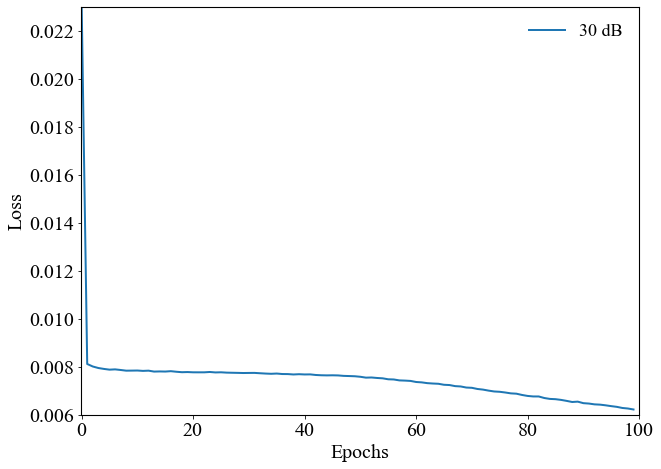

In [84]:
# Load the JSON file containing the training history
with open('./new_model/history_per_snr_5.json', 'r') as json_file:
    results = json.load(json_file)

# Define font properties
fontname = 'Times New Roman'
fontsize = 20
legendsize = 18
linewidth = 2
markersize = 10

# Set global font properties
plt.rc('font', family=fontname, size=fontsize)

# Extract the loss values for each SNR
history_per_snr = results

# Define the SNR values to be plotted
selected_snr_values = ['SNR_30']

# Create a plot for the loss over epochs for the selected SNR values
plt.figure(figsize=(10, 7.5))  # Adjusted to 800x600 in pixel terms assuming 100 DPI
for snr, history in history_per_snr.items():
    if snr in selected_snr_values:
        plt.plot(history['loss'], label=f'{snr.replace("SNR_", "")} dB', linewidth=linewidth)

# Customize axes
plt.xlabel('Epochs', fontsize=fontsize, fontname=fontname)
plt.ylabel('Loss', fontsize=fontsize, fontname=fontname)
plt.ylim([0.0060, 0.02300])
plt.xlim([-0.1, 100])

# Customizing legend
legend_prop = FontProperties(family=fontname, size=legendsize)
legend = plt.legend(frameon=False, prop=legend_prop)
for line in legend.get_lines():
    line.set_linewidth(2.0)  # Increase width of legend lines

# Customize grid and borders
plt.grid(False)
plt.gca().spines['top'].set_linewidth(1.1)
plt.gca().spines['right'].set_linewidth(1.1)
plt.gca().spines['left'].set_linewidth(1.1)
plt.gca().spines['bottom'].set_linewidth(1.1)

plt.savefig(f'new_model_loss_100epochs.png', format='png')
plt.savefig(f'new_model_loss_100epochs.eps', format='eps')

plt.show()

C:\Users\edu_l\AppData\Local\Temp\ipykernel_12968\3261327077.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


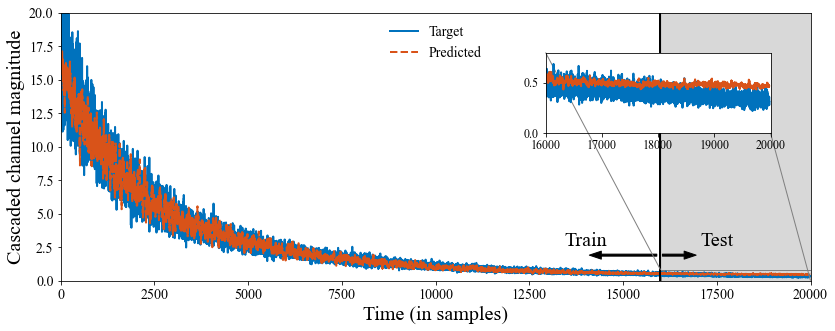

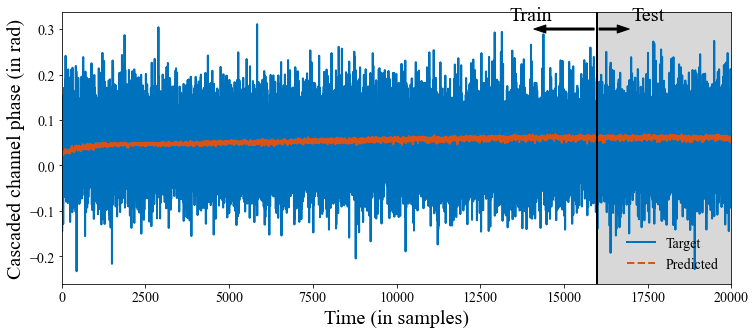

C:\Users\edu_l\AppData\Local\Temp\ipykernel_12968\3261327077.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


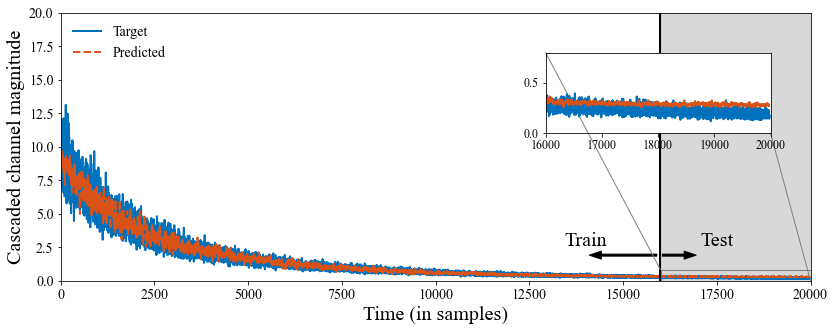

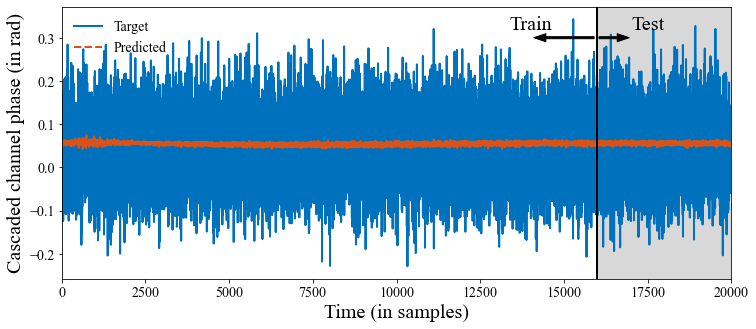

In [74]:
plotter = GeneratePlots(y_true_all_2[:,:,:,:,8], y_pred_all_2[:,:,:,:,8])
plotter.plot_model_evaluation()

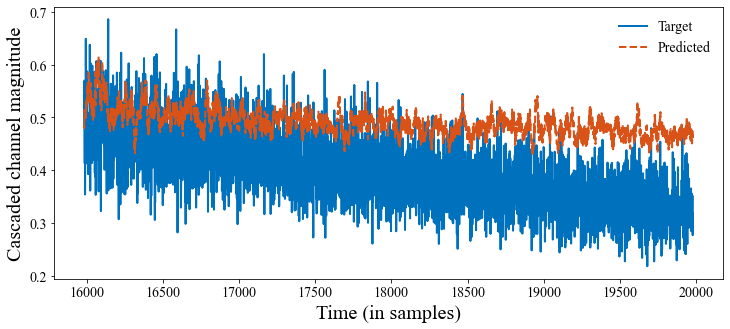

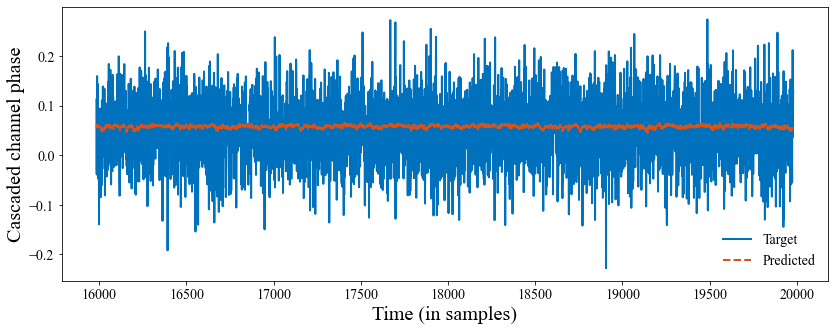

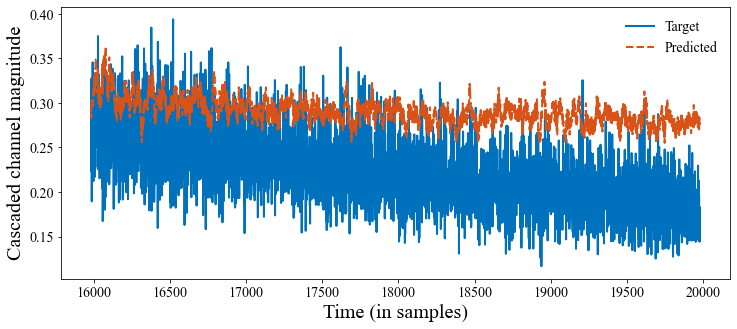

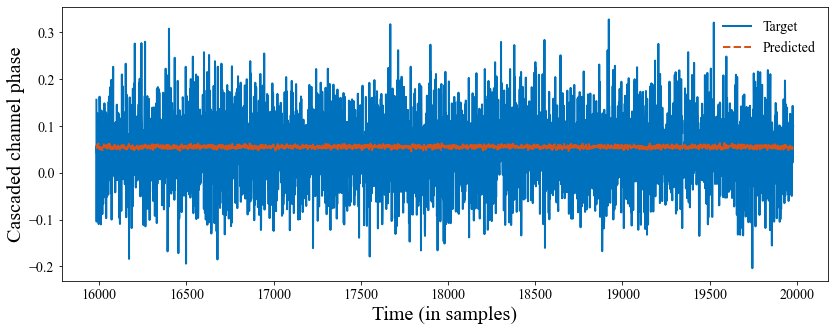

NRMSE: 0.10566958334801126
MASE: 0.057591269014591134
MAPE: 56.120422803572964
R2 Score: 0.19059707326138253
RMSE: 0.07768544251218272
MAE: 0.06481111781197725


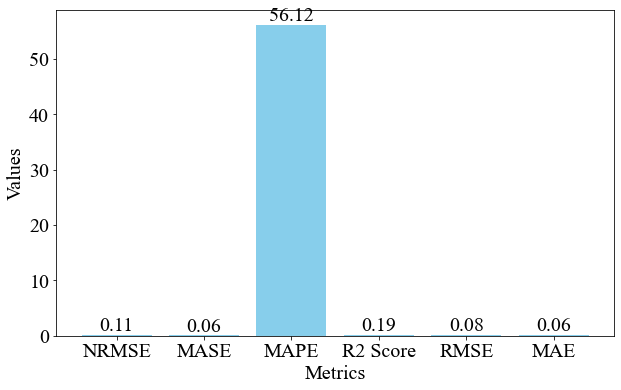

In [75]:
plotter = GeneratePlots(y_true_test_2[:,:,:,:,8], y_pred_test_2[:,:,:,:,8])
plotter.plot_model_evaluation_test()
plotter.plot_model_metrics()

In [35]:

# y_pred_test_original = processor.scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)
# y_pred_train_original = processor.scaler_y.inverse_transform(y_pred_train.reshape(-1, y_pred_train.shape[-1])).reshape(y_pred_train.shape)
# y_true_test_original = processor.scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)
# y_true_train_original = processor.scaler_y.inverse_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
# X_test_original = processor.scaler_X.inverse_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
# X_train_original = processor.scaler_X.inverse_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# y_pred_all_2 = results_2_user['y_pred_all']
# y_true_all_2 = results_2_user['y_true_all'] 
# X_all_2 = results_2_user['X_all'] 
# y_pred_test_2 = results_2_user['y_pred_test']  
# y_pred_train_save_2 = results_2_user['y_pred_train']  
# y_true_test_2 = results_2_user['y_true_test']  
# y_true_train_2 = results_2_user['y_true_train']  
# X_test_save_2 = results_2_user['X_test']  
# X_train_save_2 = results_2_user['X_train']  

print('TEST:')
print(Y[20,0,:,4])
print(X_train_save_2[1,19,0,:,4])
print(y_pred_test_2[:,:,0,0,4])
print(Y[20,1,:,4])
print('######')#X_test_save_2[20, 0, 0, :,8])
print('Channel:')
print(G[20,0,:,4])
print(y_true_train_2[0,0,0,:,4])
print(y_pred_train_save_2[0,0,0,:,4])
print('-')
print(G[20,1,:,4])
print(y_true_train_2[0,0,1,:,4])
print(y_pred_train_save_2[0,0,1,:,4])


TEST:
[ 3.89935914 -1.77376245]
[ 3.89935914 -1.77376245]
[[0.63745058]
 [0.63745058]
 [0.63745058]
 ...
 [0.63745058]
 [0.63745058]
 [0.63745058]]
[ 2.98555625 -1.796359  ]
######
Channel:
[3.90481225e+00 3.14427531e-03]
[3.90481225e+00 3.14427531e-03]
[0.63745058 0.05010905]
-
[ 2.98808563 -0.02148579]
[ 2.98808563 -0.02148579]
[0.48178697 0.04655886]


In [90]:
# List of filenames to load manually
filenames = [
    'inference_times_per_snr_8.json'
    # Add more filenames as needed
]

# Path to the directory containing your files
directory_path = './new_model/'

# List to store the results
results = []

# Load each file and calculate the average
for filename in filenames:
    file_path = f"{directory_path}{filename}"
    
    # Open and load the JSON data
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Calculate the average inference time
    average_time = sum(data.values()) / len(data)
    
    # Convert to milliseconds (if times are in seconds)
    average_time_ms = average_time * 1000
    
    # Append the result
    results.append((filename, average_time_ms))

# Print the results
for filename, avg_time in results:
    print(f'{filename}, Average Inference Time (ms): {avg_time:.6f}')

inference_times_per_snr_8.json, Average Inference Time (ms): 0.241182


In [94]:
processor = DatasetProcessor("dataset_1.mat", 20, 1, 1, 1)
model_instance = CNNLSTMModel(processor)
font = ImageFont.truetype("times.ttf", 14)
def text_callable(layer_index, layer):
    # Decide se o texto será exibido acima ou abaixo da camada
    above = bool(layer_index % 2)

    # Obtém a forma de saída da camada
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # Se a forma de saída for uma lista de tuplas, pega apenas a primeira
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variável para armazenar o texto a ser desenhado
    output_shape_txt = ""

    # Cria uma representação em string da forma de saída
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2:  # Adiciona um "x" entre as dimensões
            output_shape_txt += "x"
        if ii == len(output_shape) - 2:  # Adiciona uma nova linha entre as duas últimas dimensões
            output_shape_txt += "\n"

    # Adiciona o nome da camada ao texto, como uma nova linha
    output_shape_txt += f"\n{layer.name}"

    # Retorna o texto e a posição (acima ou abaixo da camada)
    return output_shape_txt, above


visualkeras.layered_view(model_instance.model, legend=True, show_dimension=True, type_ignore=[RepeatVector], font=font, scale_xy=15, to_file='model_visualization_4.png').show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 2, 64)         448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 2, 64)         12352     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 1, 320)           